inspired by:

https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import textwrap
import langid




In [2]:
import nltk

# Force re-download the punkt resource
nltk.download('punkt', force=True)
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

# Check all available resources and their locations
print(nltk.data.path)

[nltk_data] Downloading package punkt to /Users/juliuseg/nltk_data...


['/Users/juliuseg/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/share/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Hotel dataset
Has ratings in 1-5 if outliers pruned. Has full text

In [3]:
# Read in data
df_full = pd.read_csv('data/reviews_hotel1.csv') # https://www.kaggle.com/datasets/nikitaryabukhin/reviewshotel?select=reviews_hotel1.csv
print(df_full.shape)
# Drop nan reviews
df_full = df_full[df_full['reviews.text'].notna()]
# Strip away the reviews that seem like outliers since only 5% of the data is not in this range.
df_full = df_full[df_full['reviews.rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]
df = df_full.head(5000)
df = df.reset_index()
print(df.shape)


(35912, 4)
(5000, 5)


In [4]:
# Prune language of dataframe
df = df[df["reviews.text"].apply(lambda x: langid.classify(str(x))[0] == "en")]
# Combine title and review into one column:
df['Review'] = df['reviews.title'] + '\n' + df['reviews.text']
df.drop(columns=['reviews.title', 'reviews.text'], inplace=True)

# Rename the colomns for easier data replacement:
df.rename(columns={'reviews.rating': 'Rating'}, inplace=True)


### Dictionary approach (VADER)

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


In [6]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    # if text is float print the index and the text
    if isinstance(text, float):
        print(row['index'], text)
        continue
    myid = row['index']
    res[myid] = sia.polarity_scores(text)

print(len(res))



  0%|          | 0/4806 [00:00<?, ?it/s]

184 nan
185 nan
885 nan
925 nan
1261 nan
1262 nan
1606 nan
1668 nan
1693 nan
1694 nan
1695 nan
1696 nan
1697 nan
1698 nan
1699 nan
1700 nan
1750 nan
1751 nan
1752 nan
1753 nan
1754 nan
1765 nan
1766 nan
1767 nan
1768 nan
1769 nan
1770 nan
1771 nan
1772 nan
1773 nan
1774 nan
1775 nan
1776 nan
1777 nan
1778 nan
1779 nan
1781 nan
1782 nan
1783 nan
1784 nan
1785 nan
1786 nan
1787 nan
1788 nan
1789 nan
1790 nan
1791 nan
1794 nan
1797 nan
2577 nan
2578 nan
2579 nan
2593 nan
2594 nan
2595 nan
2661 nan
2767 nan
3151 nan
3166 nan
3348 nan
3750 nan
3751 nan
3752 nan
3753 nan
3754 nan
3755 nan
3802 nan
4293 nan
4382 nan
4444 nan
4445 nan
4730 nan
4731 nan
4732 nan
4732


In [7]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'index'})
vaders = vaders.merge(df, how='left')

In [8]:
vaders.head()

,index,neg,neu,pos,compound,reviews.date,Rating,Review
0,0,0.043,0.685,0.272,0.8924,2013-09-22T00:00:00Z,4.0,Good location away from the crouds\nPleasant 1...
1,1,0.017,0.497,0.486,0.9872,2015-04-03T00:00:00Z,5.0,Great hotel with Jacuzzi bath!\nReally lovely ...
2,3,0.000,0.700,0.300,0.9719,2013-10-27T00:00:00Z,5.0,Good location on the Lido.\nWe stayed here for...
3,4,0.000,0.719,0.281,0.9643,2015-03-05T00:00:00Z,5.0,������ ���������������\nWe stayed here for fou...
4,5,0.000,0.682,0.318,0.9802,2015-04-05T00:00:00Z,5.0,Very nice hotel\nWe loved staying on the islan...


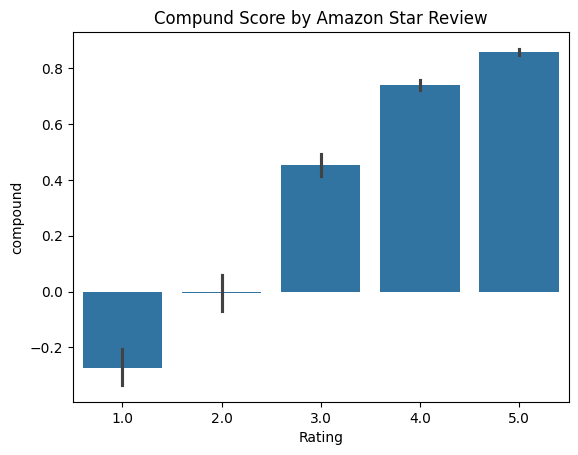

In [9]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()


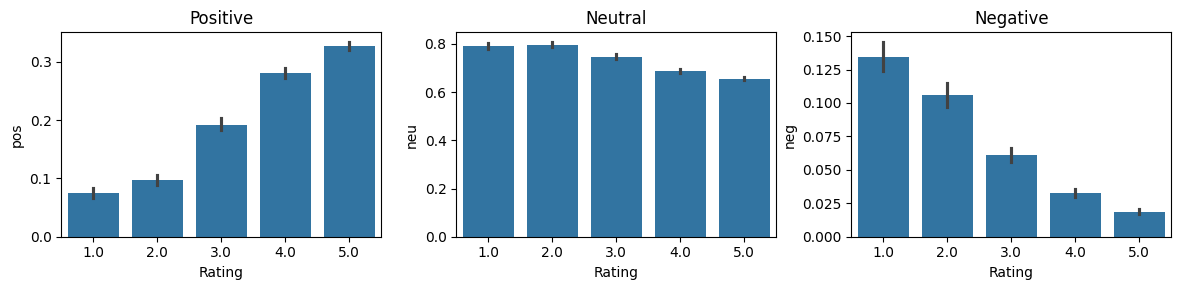

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()



### Pretrained transformer model (Roberta)

In [11]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax



In [12]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Because im using my mac m2 where metal is gpu framework (Like cuda for nvidia)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

#### Function to use to do entire dataset

In [14]:
def polarity_scores_roberta(example):
    # Tokenize and move to correct device
    encoded_text = tokenizer(example, return_tensors="pt")
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

    # Inference
    with torch.no_grad():
        output = model(**encoded_text)

    # Move back to CPU for numpy conversion
    scores = output.logits[0].to("cpu").numpy()
    scores = softmax(scores)

    # Convert to normal floats
    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }


In [15]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review']
        # if text is float print the index and the text
        if isinstance(text, float):
            print("Skipped float value on: ",row['index'], text)
            continue
        myid = row['index']
        
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/4806 [00:00<?, ?it/s]

Skipped float value on:  184 nan
Skipped float value on:  185 nan


KeyboardInterrupt: 

In [16]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'index'})
results_df = results_df.merge(df, how='left')
results_df.columns

Index(['index', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'reviews.date', 'Rating',
       'Review'],
      dtype='object')

# Analysis of results

### Rating distribution by Roberta-dominant sentiment

This shows how 1–5 star ratings are distributed within reviews where Roberta predicts negative, neutral, or positive as the highest-probability class (15 bars total).


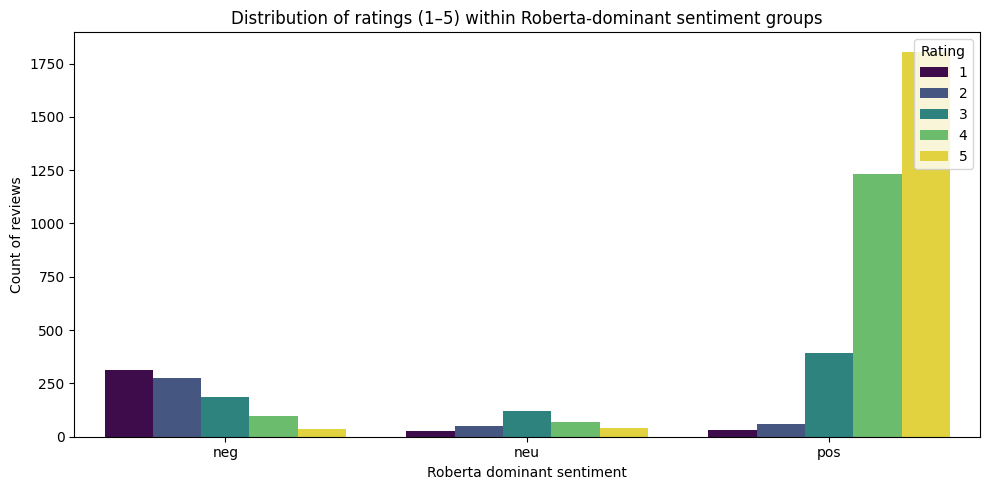

In [29]:
# Determine Roberta-dominant sentiment per review and plot 1–5 star distribution
roberta_cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']

# Guard: keep only rows where all Roberta scores exist
valid_mask = results_df[roberta_cols].notna().all(axis=1)
plot_df = results_df.loc[valid_mask].copy()

# Dominant Roberta class (neg/neu/pos)
plot_df['roberta_dom'] = plot_df[roberta_cols].idxmax(axis=1).str.replace('roberta_', '', regex=False)

# Ensure ratings are clean ints for plotting
plot_df['RatingInt'] = plot_df['Rating'].astype(int)

# Count ratings within each dominant class
counts = (
    plot_df
    .groupby(['roberta_dom', 'RatingInt'])
    .size()
    .reset_index(name='count')
)

# Consistent ordering
dom_order = ['neg', 'neu', 'pos']
rating_order = [1, 2, 3, 4, 5]

plt.figure(figsize=(10, 5))
sns.barplot(
    data=counts,
    x='roberta_dom', y='count', hue='RatingInt',
    order=dom_order, hue_order=rating_order, palette='viridis'
)
plt.title('Distribution of ratings (1–5) within Roberta-dominant sentiment groups')
plt.xlabel('Roberta dominant sentiment')
plt.ylabel('Count of reviews')
plt.legend(title='Rating', loc='upper right')
plt.tight_layout()
plt.show()


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np

# Map ratings to brackets: 1-2 -> Negative (0), 3 -> Neutral (1), 4-5 -> Positive (2)
results_df['bracket'] = results_df['Rating'].apply(
    lambda x: 0 if x <= 2 else (1 if x == 3 else 2)
)

# Extract features and labels (drop NaN)
roberta_cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']
valid_mask = results_df[roberta_cols].notna().all(axis=1)

X = results_df.loc[valid_mask, roberta_cols].values
y = results_df.loc[valid_mask, 'bracket'].values

# Train multinomial logistic regression
clf = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
clf.fit(X, y)

# Predict
y_pred = clf.predict(X)

# Report
print("Classification Report:")
print(classification_report(y, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
print(f"\nMacro F1: {f1_score(y, y_pred, average='macro'):.3f}")
print(f"\nModel weights (coefficients):")
for i, col in enumerate(roberta_cols):
    print(f"  {col}: {clf.coef_[:, i]}")



Classification Report:
              precision    recall  f1-score   support

    Negative       0.66      0.77      0.71       757
     Neutral       0.38      0.13      0.20       697
    Positive       0.85      0.94      0.89      3277

    accuracy                           0.79      4731
   macro avg       0.63      0.61      0.60      4731
weighted avg       0.75      0.79      0.76      4731


Macro F1: 0.601

Model weights (coefficients):
  roberta_neg: [ 1.68513345 -0.65367556 -1.03145789]
  roberta_neu: [-0.13985383  1.05794711 -0.91809328]
  roberta_pos: [-1.7660552  -0.34451351  2.11056871]


/Users/juliuseg/DTU/CompTools/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Confusion Matrix: How many correctly predicted per bracket?


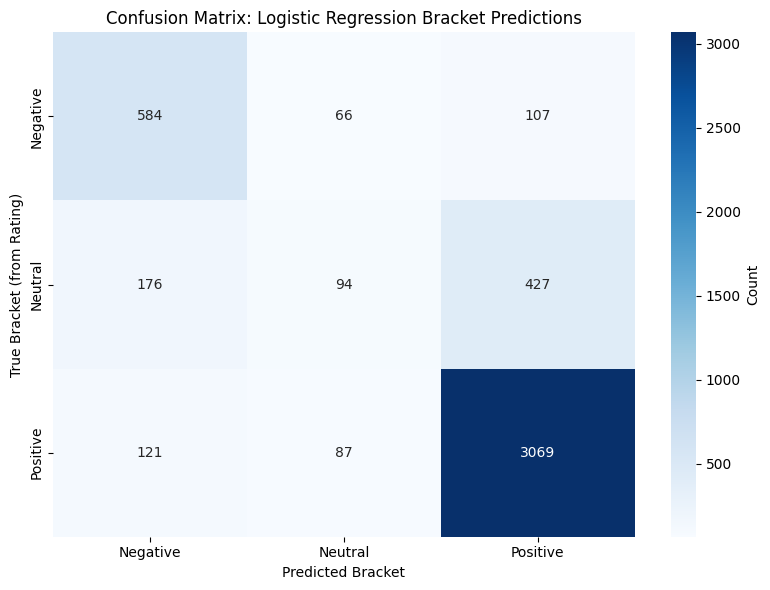


Per-bracket accuracy:
  Negative: 77.1% (584/757)
  Neutral: 13.5% (94/697)
  Positive: 93.7% (3069/3277)


In [31]:
# Compute confusion matrix
cm = confusion_matrix(y, y_pred, labels=[0, 1, 2])
bracket_names = ['Negative', 'Neutral', 'Positive']

# Plot confusion matrix as heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=bracket_names, yticklabels=bracket_names,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Bracket')
ax.set_ylabel('True Bracket (from Rating)')
ax.set_title('Confusion Matrix: Logistic Regression Bracket Predictions')
plt.tight_layout()
plt.show()

# Also show per-bracket accuracy
print("\nPer-bracket accuracy:")
for i, name in enumerate(bracket_names):
    if cm[i].sum() > 0:
        accuracy = cm[i, i] / cm[i].sum()
        print(f"  {name}: {accuracy:.1%} ({cm[i, i]}/{cm[i].sum()})")



## Repeat for VADER

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np


# Extract features and labels (drop NaN)
vader_cols = ['vader_neg', 'vader_neu', 'vader_pos']
valid_mask = results_df[vader_cols].notna().all(axis=1)

X = results_df.loc[valid_mask, vader_cols].values
y = results_df.loc[valid_mask, 'bracket'].values

# Train multinomial logistic regression
clf = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
clf.fit(X, y)

# Predict
y_pred_vader = clf.predict(X)

# Report
print("Classification Report:")
print(classification_report(y, y_pred_vader, target_names=['Negative', 'Neutral', 'Positive']))
print(f"\nMacro F1: {f1_score(y, y_pred_vader, average='macro'):.3f}")
print(f"\nModel weights (coefficients):")
for i, col in enumerate(vader_cols):
    print(f"  {col}: {clf.coef_[:, i]}")



Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.61      0.61       757
     Neutral       0.00      0.00      0.00       697
    Positive       0.79      0.96      0.86      3277

    accuracy                           0.76      4731
   macro avg       0.47      0.52      0.49      4731
weighted avg       0.64      0.76      0.70      4731


Macro F1: 0.491

Model weights (coefficients):
  vader_neg: [ 5.09103371  0.19992999 -5.29096369]
  vader_neu: [ 0.69623615 -0.51480782 -0.18142833]
  vader_pos: [-5.97051382  0.39409766  5.57641617]


/Users/juliuseg/DTU/CompTools/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


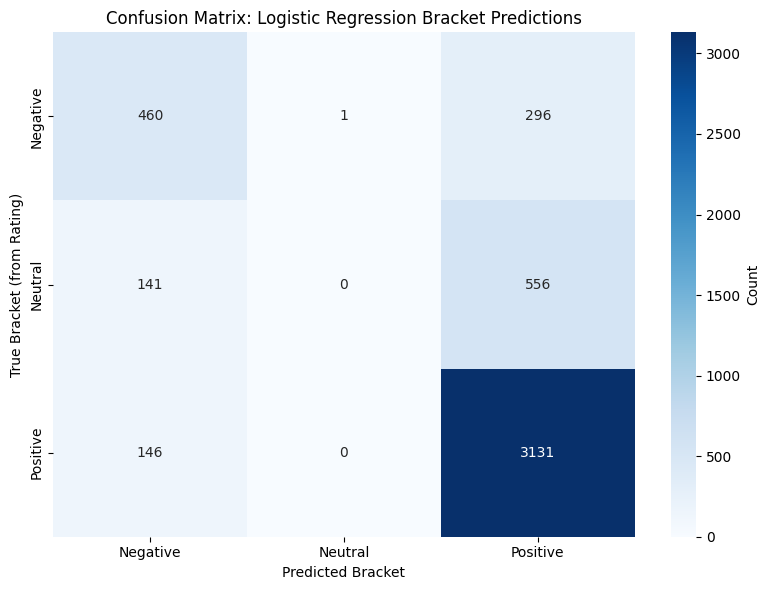


Per-bracket accuracy:
  Negative: 60.8% (460/757)
  Neutral: 0.0% (0/697)
  Positive: 95.5% (3131/3277)


In [36]:
# Compute confusion matrix
cm_vader = confusion_matrix(y, y_pred_vader, labels=[0, 1, 2])
bracket_names = ['Negative', 'Neutral', 'Positive']

# Plot confusion matrix as heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Blues', 
            xticklabels=bracket_names, yticklabels=bracket_names,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Bracket')
ax.set_ylabel('True Bracket (from Rating)')
ax.set_title('Confusion Matrix: Logistic Regression Bracket Predictions')
plt.tight_layout()
plt.show()

# Also show per-bracket accuracy
print("\nPer-bracket accuracy:")
for i, name in enumerate(bracket_names):
    if cm_vader[i].sum() > 0:
        accuracy = cm_vader[i, i] / cm_vader[i].sum()
        print(f"  {name}: {accuracy:.1%} ({cm_vader[i, i]}/{cm_vader[i].sum()})")



## Comparison between argmax Roberta and Vader

In [37]:
# Compute argmax for both Roberta and VADER
roberta_cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']
vader_cols = ['vader_neg', 'vader_neu', 'vader_pos']

# Filter to rows with valid data for both
valid_both = results_df[roberta_cols + vader_cols].notna().all(axis=1)
eval_df = results_df.loc[valid_both].copy()

# Argmax bracket for Roberta: neg->0, neu->1, pos->2
eval_df['roberta_bracket'] = eval_df[roberta_cols].idxmax(axis=1).str.replace('roberta_', '', regex=False)
eval_df['roberta_bracket_num'] = eval_df['roberta_bracket'].map({'neg': 0, 'neu': 1, 'pos': 2})

# Argmax bracket for VADER: neg->0, neu->1, pos->2
eval_df['vader_bracket'] = eval_df[vader_cols].idxmax(axis=1).str.replace('vader_', '', regex=False)
eval_df['vader_bracket_num'] = eval_df['vader_bracket'].map({'neg': 0, 'neu': 1, 'pos': 2})

# Ground truth
eval_df['true_bracket'] = eval_df['Rating'].apply(
    lambda x: 0 if x <= 2 else (1 if x == 3 else 2)
)

# Predictions
y_true = eval_df['true_bracket'].values
y_roberta = eval_df['roberta_bracket_num'].values
y_vader = eval_df['vader_bracket_num'].values

print("=" * 70)
print("COMPARISON: Roberta Argmax vs. VADER Argmax")
print("=" * 70)

# Metrics
roberta_acc = accuracy_score(y_true, y_roberta)
vader_acc = accuracy_score(y_true, y_vader)

roberta_f1 = f1_score(y_true, y_roberta, average='macro')
vader_f1 = f1_score(y_true, y_vader, average='macro')

print(f"\nAccuracy:")
print(f"  Roberta:  {roberta_acc:.1%}")
print(f"  VADER:    {vader_acc:.1%}")
print(f"  Diff:     {(roberta_acc - vader_acc):+.1%}")

print(f"\nMacro F1:")
print(f"  Roberta:  {roberta_f1:.3f}")
print(f"  VADER:    {vader_f1:.3f}")
print(f"  Diff:     {(roberta_f1 - vader_f1):+.3f}")

print(f"\n{'ROBERTA':30} Classification Report:")
print(classification_report(y_true, y_roberta, target_names=['Negative', 'Neutral', 'Positive']))

print(f"\n{'VADER':30} Classification Report:")
print(classification_report(y_true, y_vader, target_names=['Negative', 'Neutral', 'Positive']))



COMPARISON: Roberta Argmax vs. VADER Argmax

Accuracy:
  Roberta:  79.2%
  VADER:    22.2%
  Diff:     +57.0%

Macro F1:
  Roberta:  0.615
  VADER:    0.162
  Diff:     +0.453

ROBERTA                        Classification Report:
              precision    recall  f1-score   support

    Negative       0.65      0.78      0.71       757
     Neutral       0.40      0.17      0.24       697
    Positive       0.86      0.93      0.89      3277

    accuracy                           0.79      4731
   macro avg       0.64      0.63      0.61      4731
weighted avg       0.76      0.79      0.77      4731


VADER                          Classification Report:
              precision    recall  f1-score   support

    Negative       0.56      0.01      0.01       757
     Neutral       0.16      0.96      0.27       697
    Positive       0.93      0.11      0.20      3277

    accuracy                           0.22      4731
   macro avg       0.55      0.36      0.16      4731
weighte

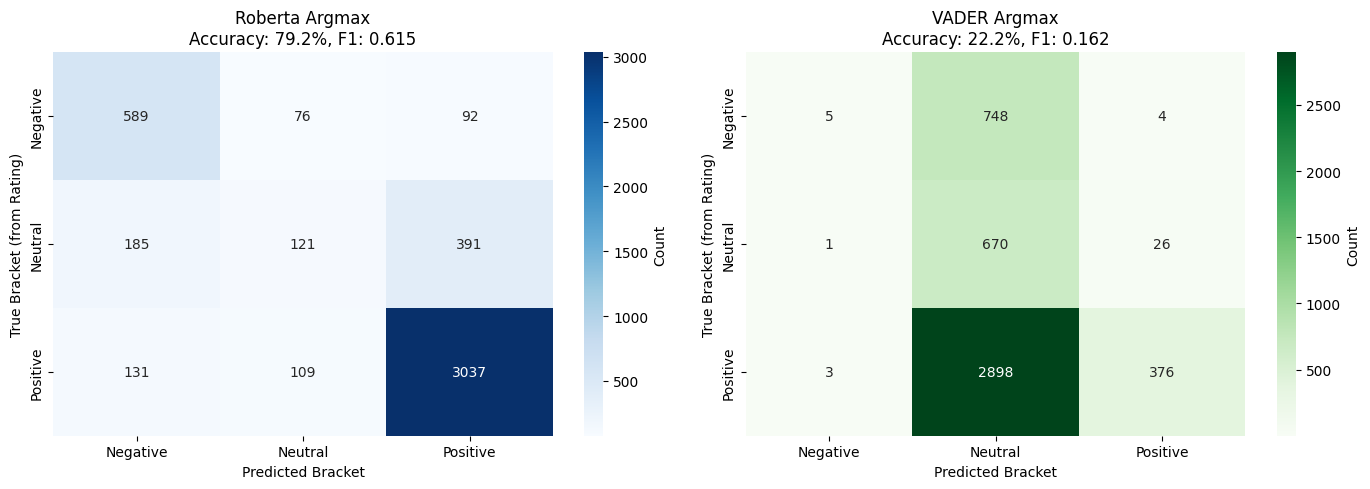


Per-bracket accuracy:

Bracket      Roberta      VADER       
----------------------------------------
Negative     77.8%           0.7%
Neutral      17.4%           96.1%
Positive     92.7%           11.5%


In [38]:
# Side-by-side confusion matrices
cm_roberta = confusion_matrix(y_true, y_roberta, labels=[0, 1, 2])
cm_vader = confusion_matrix(y_true, y_vader, labels=[0, 1, 2])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Roberta
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Blues',
            xticklabels=bracket_names, yticklabels=bracket_names,
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_xlabel('Predicted Bracket')
axes[0].set_ylabel('True Bracket (from Rating)')
axes[0].set_title(f'Roberta Argmax\nAccuracy: {roberta_acc:.1%}, F1: {roberta_f1:.3f}')

# VADER
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Greens',
            xticklabels=bracket_names, yticklabels=bracket_names,
            cbar_kws={'label': 'Count'}, ax=axes[1])
axes[1].set_xlabel('Predicted Bracket')
axes[1].set_ylabel('True Bracket (from Rating)')
axes[1].set_title(f'VADER Argmax\nAccuracy: {vader_acc:.1%}, F1: {vader_f1:.3f}')

plt.tight_layout()
plt.show()

print("\nPer-bracket accuracy:")
print(f"\n{'Bracket':<12} {'Roberta':<12} {'VADER':<12}")
print("-" * 40)
for i, name in enumerate(bracket_names):
    if cm_roberta[i].sum() > 0 and cm_vader[i].sum() > 0:
        roberta_per = cm_roberta[i, i] / cm_roberta[i].sum()
        vader_per = cm_vader[i, i] / cm_vader[i].sum()
        print(f"{name:<12} {roberta_per:.1%}           {vader_per:.1%}")



Accuracies and F1 scores of roberta and vader. 

In [42]:
# Combined accuracy Roberta and VADER:
print(f"Roberta accuracy: {(roberta_acc_comp)}")
print(f"VADER accuracy: {(vader_lr_acc)}")


Roberta accuracy: 0.7920101458465441
VADER accuracy: 0.7590361445783133


In [44]:
# Print f1 score
print(f"Roberta F1 score: {(roberta_f1_comp)}")
print(f"VADER F1 score: {(vader_lr_f1)}")


Roberta F1 score: 0.6145634369339931
VADER F1 score: 0.49141218764042743
